In [1]:
import scvelo as scv
import scanpy as sc
import numpy as np
import pandas as pd
from transpa.util import expVeloImp, leiden_cluster, expDeconv
import torch
import warnings

warnings.filterwarnings('ignore')

seed = 10
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
# load preprocessed scRNA-seq and spatial datasets
RNA_PATH = "/gpfs/gibbs/pi/zhao/tl688/seqfishdata/data/Mouse_brain/RNA_adata.h5ad"
ST_PATH = "/gpfs/gibbs/pi/zhao/tl688/seqfishdata/data/Mouse_brain/HybISS_adata.h5ad"
RNA = scv.read(RNA_PATH)
HybISS = scv.read(ST_PATH)
RNA, HybISS

(AnnData object with n_obs × n_vars = 40733 × 16907
     obs: 'CellID', 'Age', 'Region', 'Tissue', 'Class', 'Subclass', 'initial_size_spliced', 'initial_size_unspliced', 'initial_size', 'n_counts'
     var: 'GeneName', 'gene_count_corr'
     layers: 'spliced', 'unspliced',
 AnnData object with n_obs × n_vars = 4628 × 119
     obs: 'n_counts'
     var: 'GeneName'
     obsm: 'X_xy_loc', 'xy_loc')

In [2]:
HybISS = sc.read("/gpfs/gibbs/pi/zhao/tl688/seqfishdata/data/Mouse_brain/HybISS_celltype.h5ad")

In [72]:
imp_adata = sc.read("/gpfs/gibbs/pi/zhao/tl688/seqfishdata/data/Mouse_brain/gimvigat_mb_all600.h5ad")

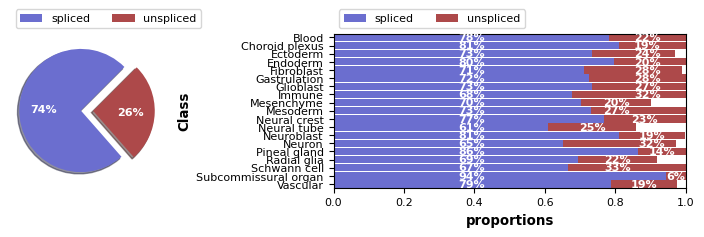

Extracted 2053 highly variable genes.
Logarithmized X.


In [73]:
scv.pl.proportions(imp_adata, 'Class')
scv.pp.filter_and_normalize(imp_adata, n_top_genes=2000, retain_genes=HybISS.var_names)

In [57]:
imp_adata.X = imp_adata.layers['spliced']

In [58]:
RNA

AnnData object with n_obs × n_vars = 40733 × 16907
    obs: 'CellID', 'Age', 'Region', 'Tissue', 'Class', 'Subclass', 'initial_size_spliced', 'initial_size_unspliced', 'initial_size', 'n_counts'
    var: 'GeneName', 'gene_count_corr'
    layers: 'spliced', 'unspliced'

In [59]:
imp_adata

AnnData object with n_obs × n_vars = 4628 × 2053
    obs: 'n_counts', 'Class', 'names', 'ind_x', '_scvi_batch', '_scvi_labels', '_scvi_ind_x', 'initial_size_unspliced', 'initial_size_spliced', 'initial_size'
    var: 'GeneName', 'gene_count_corr', 'means', 'dispersions', 'dispersions_norm', 'highly_variable'
    obsm: 'imputed', 'imputed_raw', 'imputed_raw_theta'
    layers: 'spliced', 'unspliced'

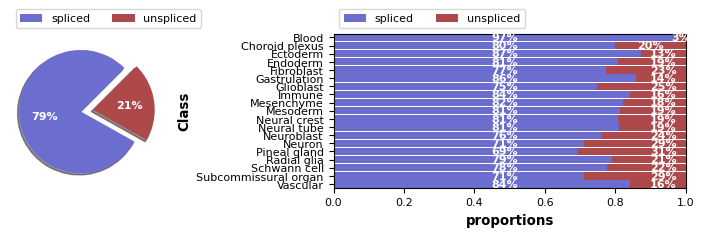

Extracted 2098 highly variable genes.


In [19]:
scv.pl.proportions(RNA, 'Class')
scv.pp.filter_and_normalize(RNA, n_top_genes=2000, retain_genes=HybISS.var_names)

In [60]:
RNA

AnnData object with n_obs × n_vars = 40733 × 16907
    obs: 'CellID', 'Age', 'Region', 'Tissue', 'Class', 'Subclass', 'initial_size_spliced', 'initial_size_unspliced', 'initial_size', 'n_counts'
    var: 'GeneName', 'gene_count_corr'
    layers: 'spliced', 'unspliced'

In [61]:
import scipy.stats as st
def calcualte_pse_correlation(adata_sc, adata_st, celltype, layer = 'spliced'):

    adata_sc.X = adata_sc.layers[layer]
    adata_st.X = adata_st.layers[layer]
    
    overlap_gene = overlap_gene = list(set(adata_sc.var_names).intersection(adata_st.var_names))
    adata_sc = adata_sc[:,overlap_gene]
    adata_st = adata_st[:,overlap_gene]
    
    cell_type_common = list(set(adata_sc.obs[celltype].unique()).intersection(adata_st.obs[celltype].unique()))
    
    pseudo_st = []
    pseudo_sc = []
    for i in cell_type_common:
        adata1 = adata_st[adata_st.obs[celltype] == i]
        adata2 = adata_sc[adata_sc.obs[celltype] == i]

        pseudo_st.append(np.mean(adata1.X.toarray(), axis = 0))
        pseudo_sc.append(np.mean(adata2.X.toarray(), axis = 0))
    
    pseudo_st = np.array(pseudo_st)
    pseudo_sc = np.array(pseudo_sc)

    cor_pearson = []
    cor_pvalue = []
    for i in range(pseudo_st.shape[1]):
        cor, pval = st.pearsonr(pseudo_st[:,i], pseudo_sc[:,i])

        if str(cor) != 'nan':
            cor_pearson.append(cor)
            cor_pvalue.append(pval)

    return np.mean(cor_pearson)

In [67]:
calcualte_pse_correlation(RNA, imp_adata, 'Class')

0.12061216994390972

In [68]:
calcualte_pse_correlation(RNA, imp_adata, 'Class', layer = 'unspliced')

0.2502001280326583

In [69]:
import scipy.stats as st
def calcualte_genegene_correlation(adata_sc, adata_st, celltype, layer = 'spliced'):

    overl_gene = list(set(RNA.var_names).intersection(imp_adata.var_names))
    adata_sc = adata_sc[:,overl_gene]
    adata_st = adata_st[:,overl_gene]

    adata_sc.X = adata_sc.layers[layer].copy()
    adata_st.X = adata_st.layers[layer].copy() 
    
    df1 = adata_sc.to_df()
    df2 = adata_st.to_df()

    df1_cor = df1.corr()
    df2_cor = df2.corr()

    cor_pearson,pval = st.pearsonr(df1_cor.values.flatten(), df2_cor.values.flatten())
    
    return cor_pearson

In [70]:
calcualte_genegene_correlation(RNA, imp_adata, 'Class', layer = 'spliced')

0.4255615774529911

In [71]:
calcualte_genegene_correlation(RNA, imp_adata, 'Class', layer = 'unspliced')

0.4255615774529911

In [44]:
import scvelo as scv
import scanpy as sc
import numpy as np
import pandas as pd
from transpa.util import expVeloImp, leiden_cluster, expDeconv
import torch
import warnings

warnings.filterwarnings('ignore')

seed = 10
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
# load preprocessed scRNA-seq and spatial datasets
RNA_PATH = "/gpfs/gibbs/pi/zhao/tl688/seqfishdata/data/Mouse_brain/RNA_adata.h5ad"
ST_PATH = "/gpfs/gibbs/pi/zhao/tl688/seqfishdata/data/Mouse_brain/HybISS_adata.h5ad"
RNA = scv.read(RNA_PATH)
HybISS = scv.read(ST_PATH)
RNA, HybISS

(AnnData object with n_obs × n_vars = 40733 × 16907
     obs: 'CellID', 'Age', 'Region', 'Tissue', 'Class', 'Subclass', 'initial_size_spliced', 'initial_size_unspliced', 'initial_size', 'n_counts'
     var: 'GeneName', 'gene_count_corr'
     layers: 'spliced', 'unspliced',
 AnnData object with n_obs × n_vars = 4628 × 119
     obs: 'n_counts'
     var: 'GeneName'
     obsm: 'X_xy_loc', 'xy_loc')

In [45]:
RNA = sc.read("/gpfs/gibbs/pi/zhao/tl688/seqfishdata/data/Mouse_brain/gimvigat_mb_all600.h5ad")

In [46]:
RNA.obsm['X_spatial'] = HybISS.obsm['X_xy_loc']

In [47]:
RNA.layers['spliced']

array([[0.02612216, 0.0281285 , 0.21423   , ..., 0.07197652, 0.12235869,
        0.20870522],
       [0.02303668, 0.01503811, 0.07456993, ..., 0.02504607, 0.02760741,
        0.10475704],
       [0.03188097, 0.01366457, 0.10259387, ..., 0.03413888, 0.0298567 ,
        0.10353794],
       ...,
       [0.01897337, 0.01458899, 0.12631649, ..., 0.03720853, 0.04221188,
        0.11854448],
       [0.04278064, 0.02130699, 0.20371476, ..., 0.05389777, 0.04669314,
        0.15585619],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]], dtype=float32)

In [48]:
RNA.layers['unspliced']

array([[0.00657997, 0.03186637, 0.18102513, ..., 0.08882491, 0.0348396 ,
        0.06476287],
       [0.00777809, 0.02717225, 0.15530692, ..., 0.06591614, 0.04340085,
        0.0679998 ],
       [0.0185655 , 0.05902795, 0.3531603 , ..., 0.15021685, 0.07268152,
        0.14448857],
       ...,
       [0.01247072, 0.04911366, 0.4017511 , ..., 0.13968596, 0.11086364,
        0.15342231],
       [0.01131952, 0.05836757, 0.38185292, ..., 0.15948527, 0.1100073 ,
        0.14792193],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]], dtype=float32)

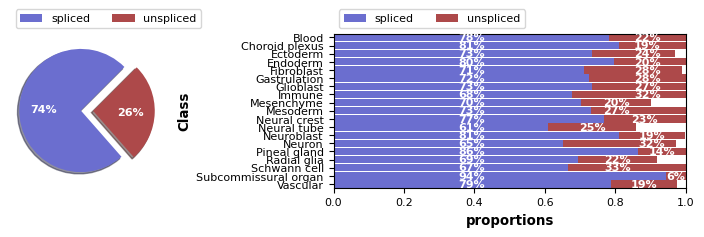

Extracted 2053 highly variable genes.
Logarithmized X.


In [49]:
scv.pl.proportions(RNA, 'Class')
scv.pp.filter_and_normalize(RNA, n_top_genes=2000, retain_genes=HybISS.var_names)

In [50]:
imp_adata = RNA
scv.pp.remove_duplicate_cells(imp_adata)

Removed 387 duplicate cells.


In [51]:
sc.pp.scale(imp_adata)
sc.tl.pca(imp_adata)
sc.pp.neighbors(imp_adata, n_neighbors=30, n_pcs=30)
sc.tl.umap(imp_adata)
sc.tl.leiden(imp_adata)


# scv.pp.moments(imp_adata, n_pcs=30, n_neighbors=30)
# scv.tl.velocity(imp_adata, vkey='stc_velocity')
# scv.tl.velocity_graph(imp_adata, vkey='stc_velocity', n_jobs=10)
# scv.tl.velocity_confidence(imp_adata, vkey='stc_velocity')

In [52]:
scv.pp.moments(imp_adata)
scv.tl.velocity(imp_adata, mode='stochastic')

computing moments based on connectivities
    finished (0:00:02) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
computing velocities
    finished (0:00:01) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)


In [53]:
sc.pp.neighbors(imp_adata)

In [54]:
scv.tl.velocity_graph(imp_adata)

computing velocity graph (using 1/16 cores)


  0%|          | 0/4241 [00:00<?, ?cells/s]

    finished (0:00:03) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


In [55]:
imp_adata

AnnData object with n_obs × n_vars = 4241 × 2053
    obs: 'n_counts', 'Class', 'names', 'ind_x', '_scvi_batch', '_scvi_labels', '_scvi_ind_x', 'initial_size_unspliced', 'initial_size_spliced', 'initial_size', 'leiden', 'velocity_self_transition'
    var: 'GeneName', 'gene_count_corr', 'means', 'dispersions', 'dispersions_norm', 'highly_variable', 'mean', 'std', 'velocity_gamma', 'velocity_qreg_ratio', 'velocity_r2', 'velocity_genes'
    uns: 'pca', 'neighbors', 'umap', 'leiden', 'velocity_params', 'velocity_graph', 'velocity_graph_neg'
    obsm: 'imputed', 'imputed_raw', 'imputed_raw_theta', 'X_spatial', 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'spliced', 'unspliced', 'Ms', 'Mu', 'velocity', 'variance_velocity'
    obsp: 'distances', 'connectivities'

In [59]:
imp_adata.obsm['spatial'] =imp_adata.obsm['X_spatial'] * np.array([[1, -1]])

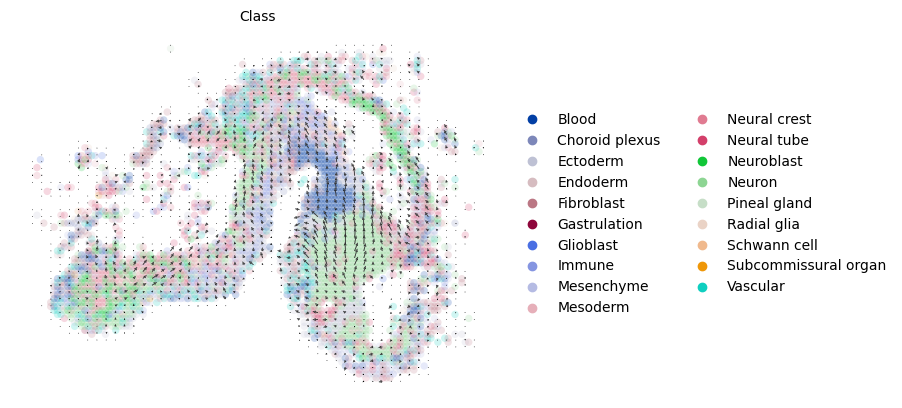

In [61]:
scv.pl.velocity_embedding_grid(imp_adata, basis='spatial', color = 'Class', legend_loc='right')

# VeloVI

In [ ]:
import numpy as np
import pandas as pd
import scanpy as sc
import scvelo as scv
import torch
from velovi import preprocess_data, VELOVI

import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
imp_adata = sc.read("/gpfs/gibbs/pi/zhao/tl688/seqfishdata/data/Mouse_brain/gimvigat_mb_all600.h5ad")

In [ ]:
HybISS = sc.read("/gpfs/gibbs/pi/zhao/tl688/seqfishdata/data/Mouse_brain/HybISS_celltype.h5ad")
imp_adata.obsm['spatial'] =HybISS.obsm['X_xy_loc'] 

In [ ]:
adata = imp_adata

In [ ]:
scv.pp.filter_and_normalize(adata, min_shared_counts=30, n_top_genes=2000)
scv.pp.moments(adata, n_pcs=30, n_neighbors=30)

In [ ]:
adata = preprocess_data(adata)
scv.pp.remove_duplicate_cells(adata)

In [ ]:
VELOVI.setup_anndata(adata, spliced_layer="Ms", unspliced_layer="Mu")
vae = VELOVI(adata)
vae.train()

In [ ]:
fig, ax = plt.subplots()
vae.history["elbo_train"].iloc[20:].plot(ax=ax, label="train")
vae.history["elbo_validation"].iloc[20:].plot(ax=ax, label="validation")
plt.legend()


In [ ]:
def add_velovi_outputs_to_adata(adata, vae):
    latent_time = vae.get_latent_time(n_samples=25)
    velocities = vae.get_velocity(n_samples=25, velo_statistic="mean")

    t = latent_time
    scaling = 20 / t.max(0)

    adata.layers["velocity"] = velocities / scaling
    adata.layers["latent_time_velovi"] = latent_time

    adata.var["fit_alpha"] = vae.get_rates()["alpha"] / scaling
    adata.var["fit_beta"] = vae.get_rates()["beta"] / scaling
    adata.var["fit_gamma"] = vae.get_rates()["gamma"] / scaling
    adata.var["fit_t_"] = (
        torch.nn.functional.softplus(vae.module.switch_time_unconstr)
        .detach()
        .cpu()
        .numpy()
    ) * scaling
    adata.layers["fit_t"] = latent_time.values * scaling[np.newaxis, :]
    adata.var['fit_scaling'] = 1.0

add_velovi_outputs_to_adata(adata, vae)

In [ ]:
scv.tl.velocity_graph(adata)

In [ ]:
scv.pl.velocity_embedding_grid(adata, basis='spatial', color = 'Class', legend_loc='right')

In [ ]:
uncertainty_df, _ = vae.get_directional_uncertainty(n_samples=100)
uncertainty_df.head()

In [ ]:
for c in uncertainty_df.columns:
    adata.obs[c] = np.log10(uncertainty_df[c].values)

In [ ]:
sc.pl.spatial(
    adata, 
    color="directional_cosine_sim_variance",
    cmap="Greys",
    vmin="p1",
    vmax="p99",
    spot_size = 1,basis='X_spatial'
    )

In [ ]:
def compute_extrinisic_uncertainty(adata, vae, n_samples=25) -> pd.DataFrame:
    from velovi._model import _compute_directional_statistics_tensor
    from scvi.utils import track
    from contextlib import redirect_stdout
    import io

    extrapolated_cells_list = []
    for i in track(range(n_samples)):
        with io.StringIO() as buf, redirect_stdout(buf):
            vkey = "velocities_velovi_{i}".format(i=i)
            v = vae.get_velocity(n_samples=1, velo_statistic="mean")
            adata.layers[vkey] = v
            scv.tl.velocity_graph(adata, vkey=vkey, sqrt_transform=False, approx=True)
            t_mat = scv.utils.get_transition_matrix(
                adata, vkey=vkey, self_transitions=True, use_negative_cosines=True
            )
            extrapolated_cells = np.asarray(t_mat @ adata.layers["Ms"])
            extrapolated_cells_list.append(extrapolated_cells)
    extrapolated_cells = np.stack(extrapolated_cells_list)
    df = _compute_directional_statistics_tensor(extrapolated_cells, n_jobs=-1, n_cells=adata.n_obs)
    return df

In [ ]:
ext_uncertainty_df = compute_extrinisic_uncertainty(adata, vae)

In [ ]:
for c in ext_uncertainty_df[0].columns:
    adata.obs[c + "_extrinisic"] = np.log10(ext_uncertainty_df[0][c].values)

In [ ]:
sc.pl.spatial(
    adata, 
    color="directional_cosine_sim_variance_extrinisic",
    vmin="p1", 
    vmax="p99", 
    spot_size = 1,
    basis='X_spatial'
)